In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as signal
import scipy.optimize as optimize
import seaborn as sns

In [2]:
results = Path('.') / 'results'
results.mkdir(exist_ok=True)

In [3]:
class Labels:
    lambda_ = 'Wellenlänge $\lambda$ / nm'
    transmission = 'Transmission / %'
    brechung = 'Brechungsindex $n$ / -'
    rep = 'Repetition'
    mess = 'Messpunkt'
    fit = 'Fit'
    psi = '$\Psi$ / $^\circ$'
    delta = '$\Delta$ / $^\circ$'
    uvvis = 'UV-VIS Spektrum von {von}'
    ellipso = 'Ellipsometriemessung von {von} auf Si'
    
class Limits:
    lambda_ = (300, 800)

In [4]:
def find_peaks(dataset, window_size: int = 10,  positive_only: bool = False, **peak_settings):
    rolling = dataset.rolling(window_size).mean().loc[window_size:]
    
    settings = dict(prominence=2, width=5)
    settings.update(peak_settings)
    pos_peaks, _ = signal.find_peaks(rolling.transmission, **settings)
    if positive_only:
        peaks = pos_peaks
    else:
        neg_peaks, _ = signal.find_peaks(-rolling.transmission, **settings)
        peaks = np.hstack([pos_peaks, neg_peaks])
    
    return rolling.iloc[peaks][['wavelength', 'transmission']].reset_index(drop=True)


In [5]:
df = pd.read_parquet('/home/jak/Documents/practical_courses/dünnschiss/data/uv_vis.parquet')
df

,wavelength,transmission,probe,repetition,prope
0,799.986450,99.749435,glas,1,glas
1,798.983093,99.868347,glas,1,glas
2,798.013794,99.535370,glas,1,glas
3,797.009582,99.559296,glas,1,glas
4,796.005005,99.427750,glas,1,glas
...,...,...,...,...,...
596,204.018021,-153.662826,filter,1,filter
597,202.992020,-179.331635,filter,1,filter
598,202.005386,50.137283,filter,1,filter
599,201.018707,94.044678,filter,1,filter


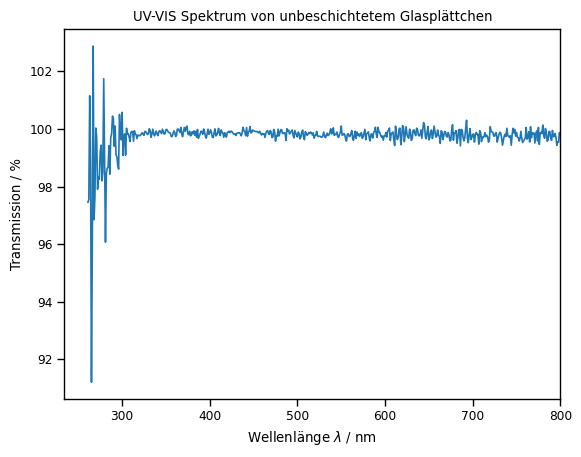

In [6]:
with sns.plotting_context('paper'):
    fig, ax = plt.subplots()
    ax.plot('wavelength', 
            'transmission',
            data=df[(df.wavelength > 260) & (df.probe == 'glas')],
           )
    ax.set_ylabel(Labels.transmission)
    ax.set_xlabel(Labels.lambda_)
    ax.set_xlim(right=Limits.lambda_[1])
    ax.set_title(Labels.uvvis.format(von='unbeschichtetem Glasplättchen'))
    fig.savefig(results/'uvvis_glasplättchen.pdf')

In [7]:
clean = df[df.wavelength > 300]

In [8]:
measures = clean.groupby('probe')

# exp fit

In [9]:
brechungs_indizes = pd.DataFrame.from_dict(
    {'MgF2': {300: 1.4054,
              400: 1.3959,
              500: 1.3917,
              600: 1.3893,
              700: 1.3878,
              800: 1.3867,
              900: 1.3859,
              1000: 1.3852,},
    'ZnS': {450: 2.473,
            500: 2.419,
            550: 2.386,
            600: 2.363,
            650: 2.345,
            700: 2.332,
            750: 2.322,
            800: 2.313,
            850: 2.306,
            900: 2.301,},
    }
).sort_index()
brechungs_indizes

,MgF2,ZnS
300,1.4054,NaN
400,1.3959,NaN
450,NaN,2.473
500,1.3917,2.419
550,NaN,2.386
600,1.3893,2.363
650,NaN,2.345
700,1.3878,2.332
750,NaN,2.322
800,1.3867,2.313


In [10]:
import matplotlib.legend as legend

In [11]:
def exp_fit(lambda_, y0, a1, t1):
    return y0 + a1*np.exp(-lambda_/t1)

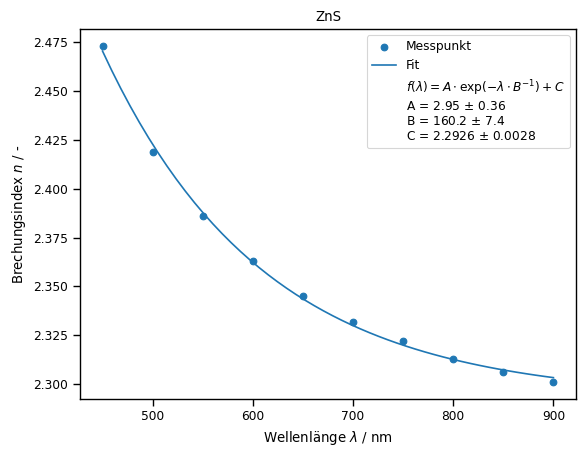

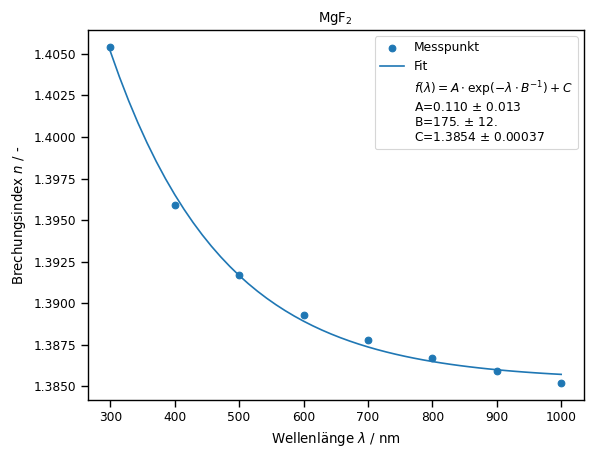

In [12]:
with sns.plotting_context('paper'):
    fig, ax = plt.subplots()
    _data = brechungs_indizes.ZnS.dropna().reset_index()
    ax.scatter('index', 'ZnS', data=_data, label=Labels.mess)
    
    zns_coeff, zns_cov = optimize.curve_fit(exp_fit,  *_data.values.T, p0=[2.3, 3, 160])
    zns_err = np.sqrt(np.diag(zns_cov))
    x = np.linspace(min(_data['index']), max(_data['index']))
    ax.plot(x, exp_fit(x, *zns_coeff), label=Labels.fit)
    
    report = '\n'.join([
        r'$f(\lambda) = A \cdot \exp\left(-\lambda\cdot B^{-1}\right) + C$', 
        '{pre}{val:#.3g} $\pm$ {err:#.2g}'.format(pre='A = ', val=zns_coeff[1], err=zns_err[1]),
        '{pre}{val:#.4g} $\pm$ {err:#.2g}'.format(pre='B = ', val=zns_coeff[2], err=zns_err[2]),
        '{pre}{val:#.5g} $\pm$ {err:#.2g}'.format(pre='C = ', val=zns_coeff[0], err=zns_err[0]),
    ])
    handles, labels = ax.get_legend_handles_labels()
    handles = list(reversed(handles))
    labels = list(reversed(labels))
    handles.append(plt.Line2D([0],[0], alpha=0))
    labels.append(report)
    
    ax.set_xlabel(Labels.lambda_)
    ax.set_ylabel(Labels.brechung)
    ax.legend(handles, labels)
    ax.set_title('ZnS')
    fig.savefig(results/'brechungsindex_zns.pdf')

    
    fig, ax = plt.subplots()
    _data = brechungs_indizes.MgF2.dropna().reset_index()
    ax.scatter('index', 'MgF2', data=_data, label=Labels.mess)
    
    mgf2_coeff, mgf2_cov = optimize.curve_fit(exp_fit,  *_data.values.T, p0=[2.3, 3, 160])
    mgf2_err = np.sqrt(np.diag(mgf2_cov))
    x = np.linspace(min(_data['index']), max(_data['index']))
    ax.plot(x, exp_fit(x, *mgf2_coeff), label=Labels.fit)
    
    report = '\n'.join([
        r'$f(\lambda) = A \cdot \exp\left(-\lambda\cdot B^{-1}\right) + C$', 
        '{pre}{val:#.3g} $\pm$ {err:#.2g}'.format(pre='A=', val=mgf2_coeff[1], err=mgf2_err[1]),
        '{pre}{val:#.3g} $\pm$ {err:#.2g}'.format(pre='B=', val=mgf2_coeff[2], err=mgf2_err[2]),
        '{pre}{val:#.5g} $\pm$ {err:#.2g}'.format(pre='C=', val=mgf2_coeff[0], err=mgf2_err[0]),
    ])
    handles, labels = ax.get_legend_handles_labels()
    handles = list(reversed(handles))
    labels = list(reversed(labels))
    handles.append(plt.Line2D([0],[0], alpha=0))
    labels.append(report)
    
    ax.set_xlabel(Labels.lambda_)
    ax.set_ylabel(Labels.brechung)
    ax.legend(handles, labels)
    ax.set_title('MgF$_2$')
    fig.savefig(results/'brechungsindex_mgf2.pdf')

# ZnS

In [13]:
reps = measures.get_group('zns').groupby('repetition')
reps.get_group(1)

,wavelength,transmission,probe,repetition,prope
0,799.986450,83.718719,zns,1,zns
1,798.983093,84.430206,zns,1,zns
2,798.013794,84.092209,zns,1,zns
3,797.009582,83.958305,zns,1,zns
4,796.005005,84.291893,zns,1,zns
...,...,...,...,...,...
495,304.996613,1.719087,zns,1,zns
496,303.980835,1.597029,zns,1,zns
497,303.003998,1.631553,zns,1,zns
498,301.987976,1.593402,zns,1,zns


/tmp/ipykernel_1430751/4278057050.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['probe', 'prope'], dtype='object')
  rolling = dataset.rolling(window_size).mean().loc[window_size:]
/tmp/ipykernel_1430751/4278057050.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['probe', 'prope'], dtype='object')
  rolling = dataset.rolling(window_size).mean().loc[window_size:]


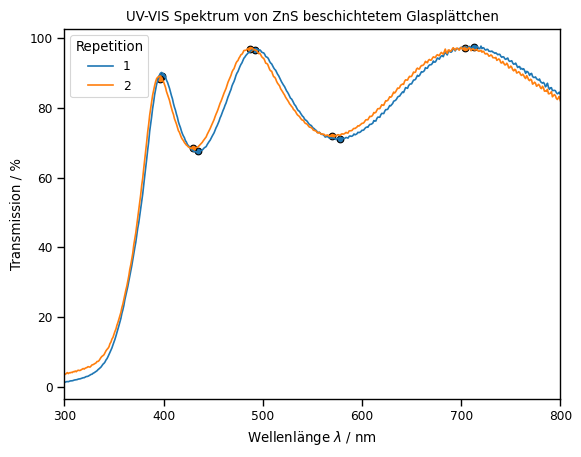

In [14]:
with sns.plotting_context('paper'):
    fig, ax = plt.subplots()

    ax.plot('wavelength', 'transmission', data=reps.get_group(1), label=1)
    ax.scatter(x='wavelength', y='transmission', data=find_peaks(reps.get_group(1)), ec='k', label=None)

    ax.plot('wavelength', 'transmission', data=reps.get_group(2), label=2)
    ax.scatter(x='wavelength', y='transmission', data=find_peaks(reps.get_group(2)), ec='k', label=None)
    ax.set_xlabel(Labels.lambda_)
    ax.set_ylabel(Labels.transmission)
    ax.legend(title=Labels.rep)
    ax.set_xlim(Limits.lambda_)
    ax.set_title(Labels.uvvis.format(von='ZnS beschichtetem Glasplättchen'))
    fig.savefig(results/'uvvis_zns.pdf')

In [15]:
df_zns = pd.concat([find_peaks(group).sort_values('wavelength').reset_index(drop=True).assign(name=name) for name, group in reps])
df_zns['n'] = exp_fit(df_zns['wavelength'], *zns_coeff)
df_zns['l/n'] = df_zns.wavelength / df_zns.n
df_zns

/tmp/ipykernel_1430751/4278057050.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['probe', 'prope'], dtype='object')
  rolling = dataset.rolling(window_size).mean().loc[window_size:]
/tmp/ipykernel_1430751/4278057050.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['probe', 'prope'], dtype='object')
  rolling = dataset.rolling(window_size).mean().loc[window_size:]


,wavelength,transmission,name,n,l/n
0,398.498831,89.087383,1,2.537938,157.016747
1,434.501474,67.499020,1,2.488545,174.600625
2,492.501169,96.597421,1,2.429010,202.757946
3,577.500336,71.104586,1,2.372830,243.380456
4,712.514124,97.323046,1,2.327126,306.177739
0,396.501331,88.150931,2,2.541018,156.040374
1,429.502249,68.458952,2,2.494758,172.161898
2,487.500150,96.721725,2,2.433337,200.342186
3,569.497931,72.004413,2,2.376941,239.592826
4,703.500983,96.925352,2,2.329125,302.045159


In [16]:
df_zns['m'] = [4, 3, 3, 2, 2]*2
df_zns

,wavelength,transmission,name,n,l/n,m
0,398.498831,89.087383,1,2.537938,157.016747,4
1,434.501474,67.499020,1,2.488545,174.600625,3
2,492.501169,96.597421,1,2.429010,202.757946,3
3,577.500336,71.104586,1,2.372830,243.380456,2
4,712.514124,97.323046,1,2.327126,306.177739,2
0,396.501331,88.150931,2,2.541018,156.040374,4
1,429.502249,68.458952,2,2.494758,172.161898,3
2,487.500150,96.721725,2,2.433337,200.342186,3
3,569.497931,72.004413,2,2.376941,239.592826,2
4,703.500983,96.925352,2,2.329125,302.045159,2


In [17]:
df_zns.loc[[0, 2, 4], 'd_geo'] = (df_zns.m * df_zns['l/n'] * 1/2).loc[[0, 2, 4]]
df_zns.loc[[1, 3], 'd_geo'] = ((2*df_zns.m+1) * df_zns['l/n'] * 1/4).loc[[1, 3]]
df_zns

,wavelength,transmission,name,n,l/n,m,test
0,398.498831,89.087383,1,2.537938,157.016747,4,314.033494
1,434.501474,67.499020,1,2.488545,174.600625,3,305.551094
2,492.501169,96.597421,1,2.429010,202.757946,3,304.136919
3,577.500336,71.104586,1,2.372830,243.380456,2,304.225570
4,712.514124,97.323046,1,2.327126,306.177739,2,306.177739
0,396.501331,88.150931,2,2.541018,156.040374,4,312.080748
1,429.502249,68.458952,2,2.494758,172.161898,3,301.283322
2,487.500150,96.721725,2,2.433337,200.342186,3,300.513279
3,569.497931,72.004413,2,2.376941,239.592826,2,299.491033
4,703.500983,96.925352,2,2.329125,302.045159,2,302.045159


# MgF2

In [18]:
reps = measures.get_group('mgf2').groupby('repetition')
reps.get_group(1)

,wavelength,transmission,probe,repetition,prope
0,799.986450,96.418015,mgf2,1,mgf2
1,798.983093,97.446655,mgf2,1,mgf2
2,798.013794,97.108505,mgf2,1,mgf2
3,797.009582,96.132462,mgf2,1,mgf2
4,796.005005,96.273911,mgf2,1,mgf2
...,...,...,...,...,...
495,304.996613,96.668365,mgf2,1,mgf2
496,303.980835,96.048103,mgf2,1,mgf2
497,303.003998,96.633263,mgf2,1,mgf2
498,301.987976,96.748276,mgf2,1,mgf2


/tmp/ipykernel_1430751/4278057050.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['probe', 'prope'], dtype='object')
  rolling = dataset.rolling(window_size).mean().loc[window_size:]
/tmp/ipykernel_1430751/4278057050.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['probe', 'prope'], dtype='object')
  rolling = dataset.rolling(window_size).mean().loc[window_size:]
/tmp/ipykernel_1430751/4278057050.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['probe', 'prope'], dtype='object')
  rolli

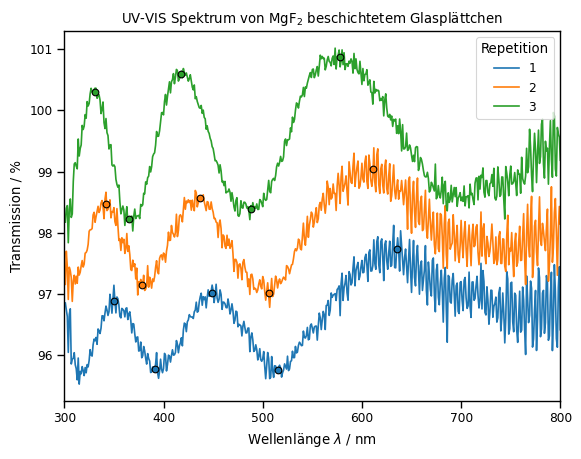

In [19]:
with sns.plotting_context('paper'):
    fig, ax = plt.subplots()

    for i in range(1, 4):
        ax.plot('wavelength', 'transmission', data=reps.get_group(i), label=i)
        ax.scatter(x='wavelength', y='transmission', data=find_peaks(reps.get_group(i), prominence=1), ec='k', zorder=10, label=None)

    ax.set_xlabel(Labels.lambda_)
    ax.set_ylabel(Labels.transmission)
    ax.legend(title=Labels.rep)
    ax.set_xlim(Limits.lambda_)
    ax.set_title(Labels.uvvis.format(von='MgF$_2$ beschichtetem Glasplättchen'))
    fig.savefig(results/'uvvis_mgf2.pdf')

In [20]:
df_mgf2 = pd.concat([find_peaks(group, prominence=1).sort_values('wavelength').reset_index(drop=True).assign(name=name) for name, group in reps])
df_mgf2['n'] = exp_fit(df_mgf2['wavelength'], *mgf2_coeff)
df_mgf2['l/n'] = df_mgf2.wavelength / df_mgf2.n
df_mgf2

/tmp/ipykernel_1430751/4278057050.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['probe', 'prope'], dtype='object')
  rolling = dataset.rolling(window_size).mean().loc[window_size:]
/tmp/ipykernel_1430751/4278057050.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['probe', 'prope'], dtype='object')
  rolling = dataset.rolling(window_size).mean().loc[window_size:]
/tmp/ipykernel_1430751/4278057050.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['probe', 'prope'], dtype='object')
  rolli

,wavelength,transmission,name,n,l/n
0,350.501239,96.887949,1,1.400194,250.323360
1,391.500928,95.780560,1,1.397096,280.224817
2,448.497604,97.020632,1,1.393834,321.772618
3,515.501163,95.762000,1,1.391139,370.560514
4,635.502966,97.735555,1,1.388272,457.765425
0,341.501385,98.463767,2,1.400977,243.759506
1,378.499277,97.149170,2,1.398001,270.743232
2,436.501443,98.562114,2,1.394435,313.031018
3,506.502081,97.020832,2,1.391444,364.011889
4,611.498730,99.045882,2,1.388700,440.339007


In [21]:
df_mgf2['m'] = [5, 4, 4, 3, 3]*3
df_mgf2

,wavelength,transmission,name,n,l/n,m
0,350.501239,96.887949,1,1.400194,250.323360,5
1,391.500928,95.780560,1,1.397096,280.224817,4
2,448.497604,97.020632,1,1.393834,321.772618,4
3,515.501163,95.762000,1,1.391139,370.560514,3
4,635.502966,97.735555,1,1.388272,457.765425,3
0,341.501385,98.463767,2,1.400977,243.759506,5
1,378.499277,97.149170,2,1.398001,270.743232,4
2,436.501443,98.562114,2,1.394435,313.031018,4
3,506.502081,97.020832,2,1.391444,364.011889,3
4,611.498730,99.045882,2,1.388700,440.339007,3


In [22]:
df_mgf2.loc[[0, 2, 4], 'd_geo'] = ((2*df_mgf2.m-1) * df_mgf2['l/n'] * 1/4).loc[[0, 2, 4]]
df_mgf2.loc[[1, 3], 'd_geo'] = ((2*df_mgf2.m) * df_mgf2['l/n'] * 1/4).loc[[1, 3]]
df_mgf2

,wavelength,transmission,name,n,l/n,m,test
0,350.501239,96.887949,1,1.400194,250.323360,5,563.227559
1,391.500928,95.780560,1,1.397096,280.224817,4,560.449635
2,448.497604,97.020632,1,1.393834,321.772618,4,563.102082
3,515.501163,95.762000,1,1.391139,370.560514,3,555.840772
4,635.502966,97.735555,1,1.388272,457.765425,3,572.206781
0,341.501385,98.463767,2,1.400977,243.759506,5,548.458889
1,378.499277,97.149170,2,1.398001,270.743232,4,541.486463
2,436.501443,98.562114,2,1.394435,313.031018,4,547.804282
3,506.502081,97.020832,2,1.391444,364.011889,3,546.017834
4,611.498730,99.045882,2,1.388700,440.339007,3,550.423759


# schmalband

In [23]:
reps = measures.get_group('filter').groupby('repetition')
reps.get_group(1)

,wavelength,transmission,probe,repetition,prope
0,799.986450,94.044891,filter,1,filter
1,798.983093,94.403847,filter,1,filter
2,798.013794,94.700218,filter,1,filter
3,797.009582,94.953621,filter,1,filter
4,796.005005,94.829391,filter,1,filter
...,...,...,...,...,...
495,304.996613,0.083496,filter,1,filter
496,303.980835,0.131268,filter,1,filter
497,303.003998,0.110071,filter,1,filter
498,301.987976,0.030353,filter,1,filter


/tmp/ipykernel_1430751/4278057050.py:2: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['probe', 'prope'], dtype='object')
  rolling = dataset.rolling(window_size).mean().loc[window_size:]


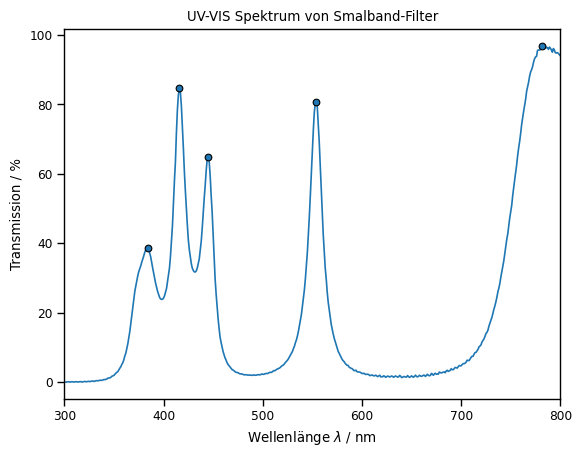

In [24]:
with sns.plotting_context('paper'):
    fig, ax = plt.subplots()

    ax.plot('wavelength', 'transmission', data=reps.get_group(1))
    _peaks = find_peaks(reps.get_group(1), window_size=1, positive_only=True)
    ax.scatter(x='wavelength', y='transmission', data=_peaks, ec='k', zorder=10)

    ax.set_ylabel(Labels.transmission)
    ax.set_xlabel(Labels.lambda_)
    ax.set_xlim(Limits.lambda_)
    ax.set_title(Labels.uvvis.format(von='Smalband-Filter'))
    fig.savefig(results / 'uvvis_schmalband.pdf')

## gauss kurve
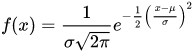

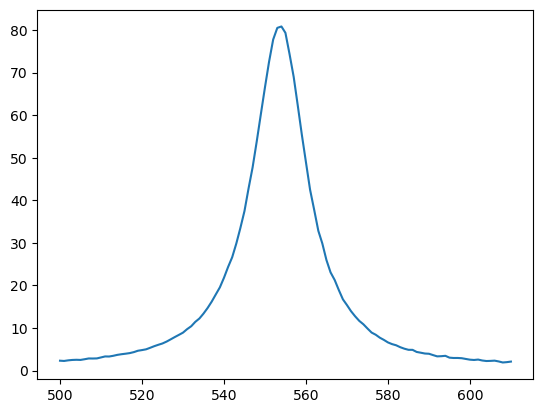

In [25]:
data=reps.get_group(1)
data = data[(data.wavelength > 500) & (data.wavelength < 610)]
plt.plot('wavelength', 'transmission', data=data)

In [26]:
def gauss(lambda_, mu, sigma, c):
    norm = sigma*np.sqrt(2*np.pi)
    expfrac = ((lambda_ - mu)/sigma)**2
    return c/norm * np.exp(-1/2 * expfrac)

In [27]:
gauss_coeff, gauss_cov = optimize.curve_fit(gauss, data.wavelength, data.transmission, 
                               p0=[550, 20, 80], 
                               bounds=[(520, 1, 0), (580, 100, 100_000)], 
                               method='trf')
gauss_err = np.sqrt(np.diag(gauss_cov))
gauss_err

array([ 0.20835847,  0.20835722, 32.49508146])

In [28]:
# fwhm
2.355 * gauss_coeff[1]

20.528553929125287

In [29]:
# höhe
gauss(gauss_coeff[0], *gauss_coeff)

71.84338393024784

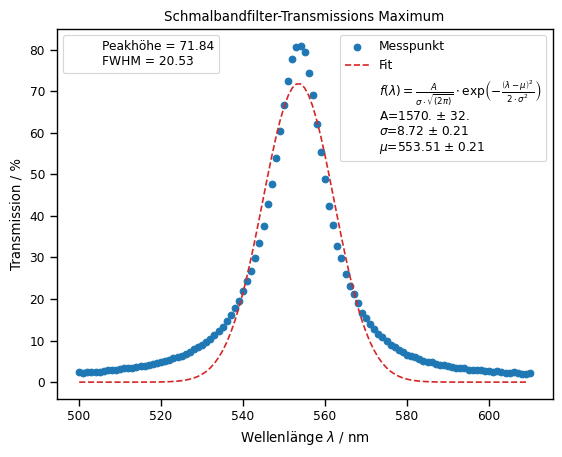

In [30]:
with sns.plotting_context('paper'):
    fig, ax = plt.subplots()
    ax.scatter('wavelength', 'transmission', data=data, label=Labels.mess)
    x = np.arange(min(data.wavelength), max(data.wavelength))
    ax.plot(x, gauss(x, *gauss_coeff), linestyle='--', color='C3', label=Labels.fit)
    
    report = '\n'.join([
        r'$f(\lambda) = \frac{A}{\sigma\cdot\sqrt{(2\pi)}} \cdot \exp\left(-\frac{\left(\lambda - \mu\right)^2}{2\cdot\sigma^2}\right)$', 
        '{pre}{val:#.4g} $\pm$ {err:#.2g}'.format(pre='A=', val=gauss_coeff[2], err=gauss_err[2]),
        '{pre}{val:#.3g} $\pm$ {err:#.2g}'.format(pre='$\sigma$=', val=gauss_coeff[1], err=gauss_err[1]),
        '{pre}{val:#.5g} $\pm$ {err:#.2g}'.format(pre='$\mu$=', val=gauss_coeff[0], err=gauss_err[0]),
        
    ])
    handles, labels = ax.get_legend_handles_labels()
    handles = list(reversed(handles))
    labels = list(reversed(labels))
    handles.append(plt.Line2D([0],[0], alpha=0))
    labels.append(report)
    
    _leg = legend.Legend(ax, handles=[plt.Line2D([],[], alpha=0)], labels=[
        f'Peakhöhe = 71.84\nFWHM = 20.53'
    ], loc='upper left')
    ax.add_artist(_leg)
    
    ax.set_xlabel(Labels.lambda_)
    ax.set_ylabel(Labels.transmission)
    ax.legend(handles, labels)
    ax.set_title('Schmalbandfilter-Transmissions Maximum')
    fig.savefig(results/'uvvis_schmalbandfilter_max.pdf')

# ellipsometrie

In [31]:
ellipso = pd.read_csv('data/ellipsometrie_mess.csv', names=['psi', 'delta', 'dicke', 'probe'], skiprows=1)
ellipso

,psi,delta,dicke,probe
0,28.8479,175.8536,5.2826,SiO2-Schichten auf Si
1,29.0279,162.8210,23.0023,SiO2-Schichten auf Si
2,31.0877,144.2351,51.4055,SiO2-Schichten auf Si
3,33.9705,133.7574,72.7511,SiO2-Schichten auf Si
4,39.7496,128.3295,92.0783,SiO2-Schichten auf Si
5,45.7468,130.2244,103.0242,SiO2-Schichten auf Si
6,29.5879,196.2043,238.0943,SiO2-Schichten auf Si
7,31.6750,222.8127,197.2465,SiO2-Schichten auf Si
8,55.5865,217.5981,144.2024,SiO2-Schichten auf Si
9,42.7681,129.0558,98.1570,SiO2-Schichten auf Si


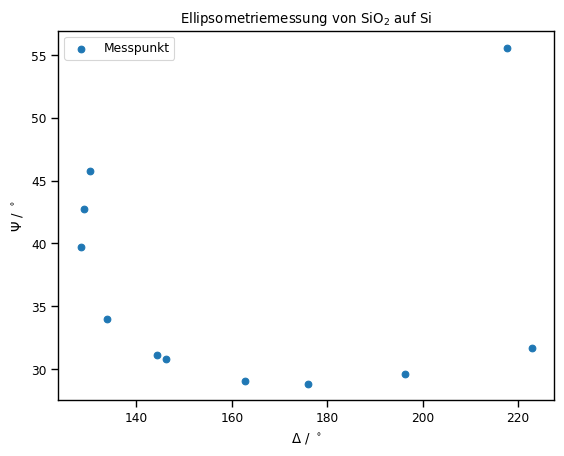

In [32]:
with sns.plotting_context('paper'):
    fig, ax = plt.subplots()
    ax.scatter('delta', 'psi', data=ellipso.query('probe=="SiO2-Schichten auf Si"'), label=Labels.mess)
    ax.legend()
    ax.set_xlabel(Labels.delta)
    ax.set_ylabel(Labels.psi)
    ax.set_title(Labels.ellipso.format(von='SiO$_2$'))
    fig.savefig(results/'ellipso_sio2.pdf')

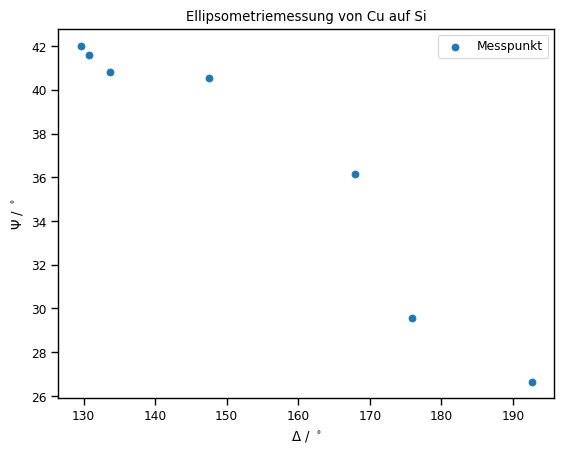

In [33]:
with sns.plotting_context('paper'):
    fig, ax = plt.subplots()
    ax.scatter('delta', 'psi', data=ellipso.query('probe=="Cu-Schichten auf Si"'), label=Labels.mess)
    ax.legend()
    ax.set_xlabel(Labels.delta)
    ax.set_ylabel(Labels.psi)
    ax.set_title(Labels.ellipso.format(von='Cu'))
    fig.savefig(results/'ellipso_cu.pdf')